In [108]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

# Models and training tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import copy
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

from BestModelFinders import ANNModel, init_weights, find_best_Ridge, find_best_KNN, find_best_RF, find_best_ANN, find_best_logistic

# Statistics tools
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import statsmodels.formula.api as smf
from itertools import combinations

Import data

In [ ]:
HR_data = pd.read_csv('HR_data.csv')
HR_data.head()
scaler = StandardScaler()

Create scatterplots of all input scatterplots against frustration.

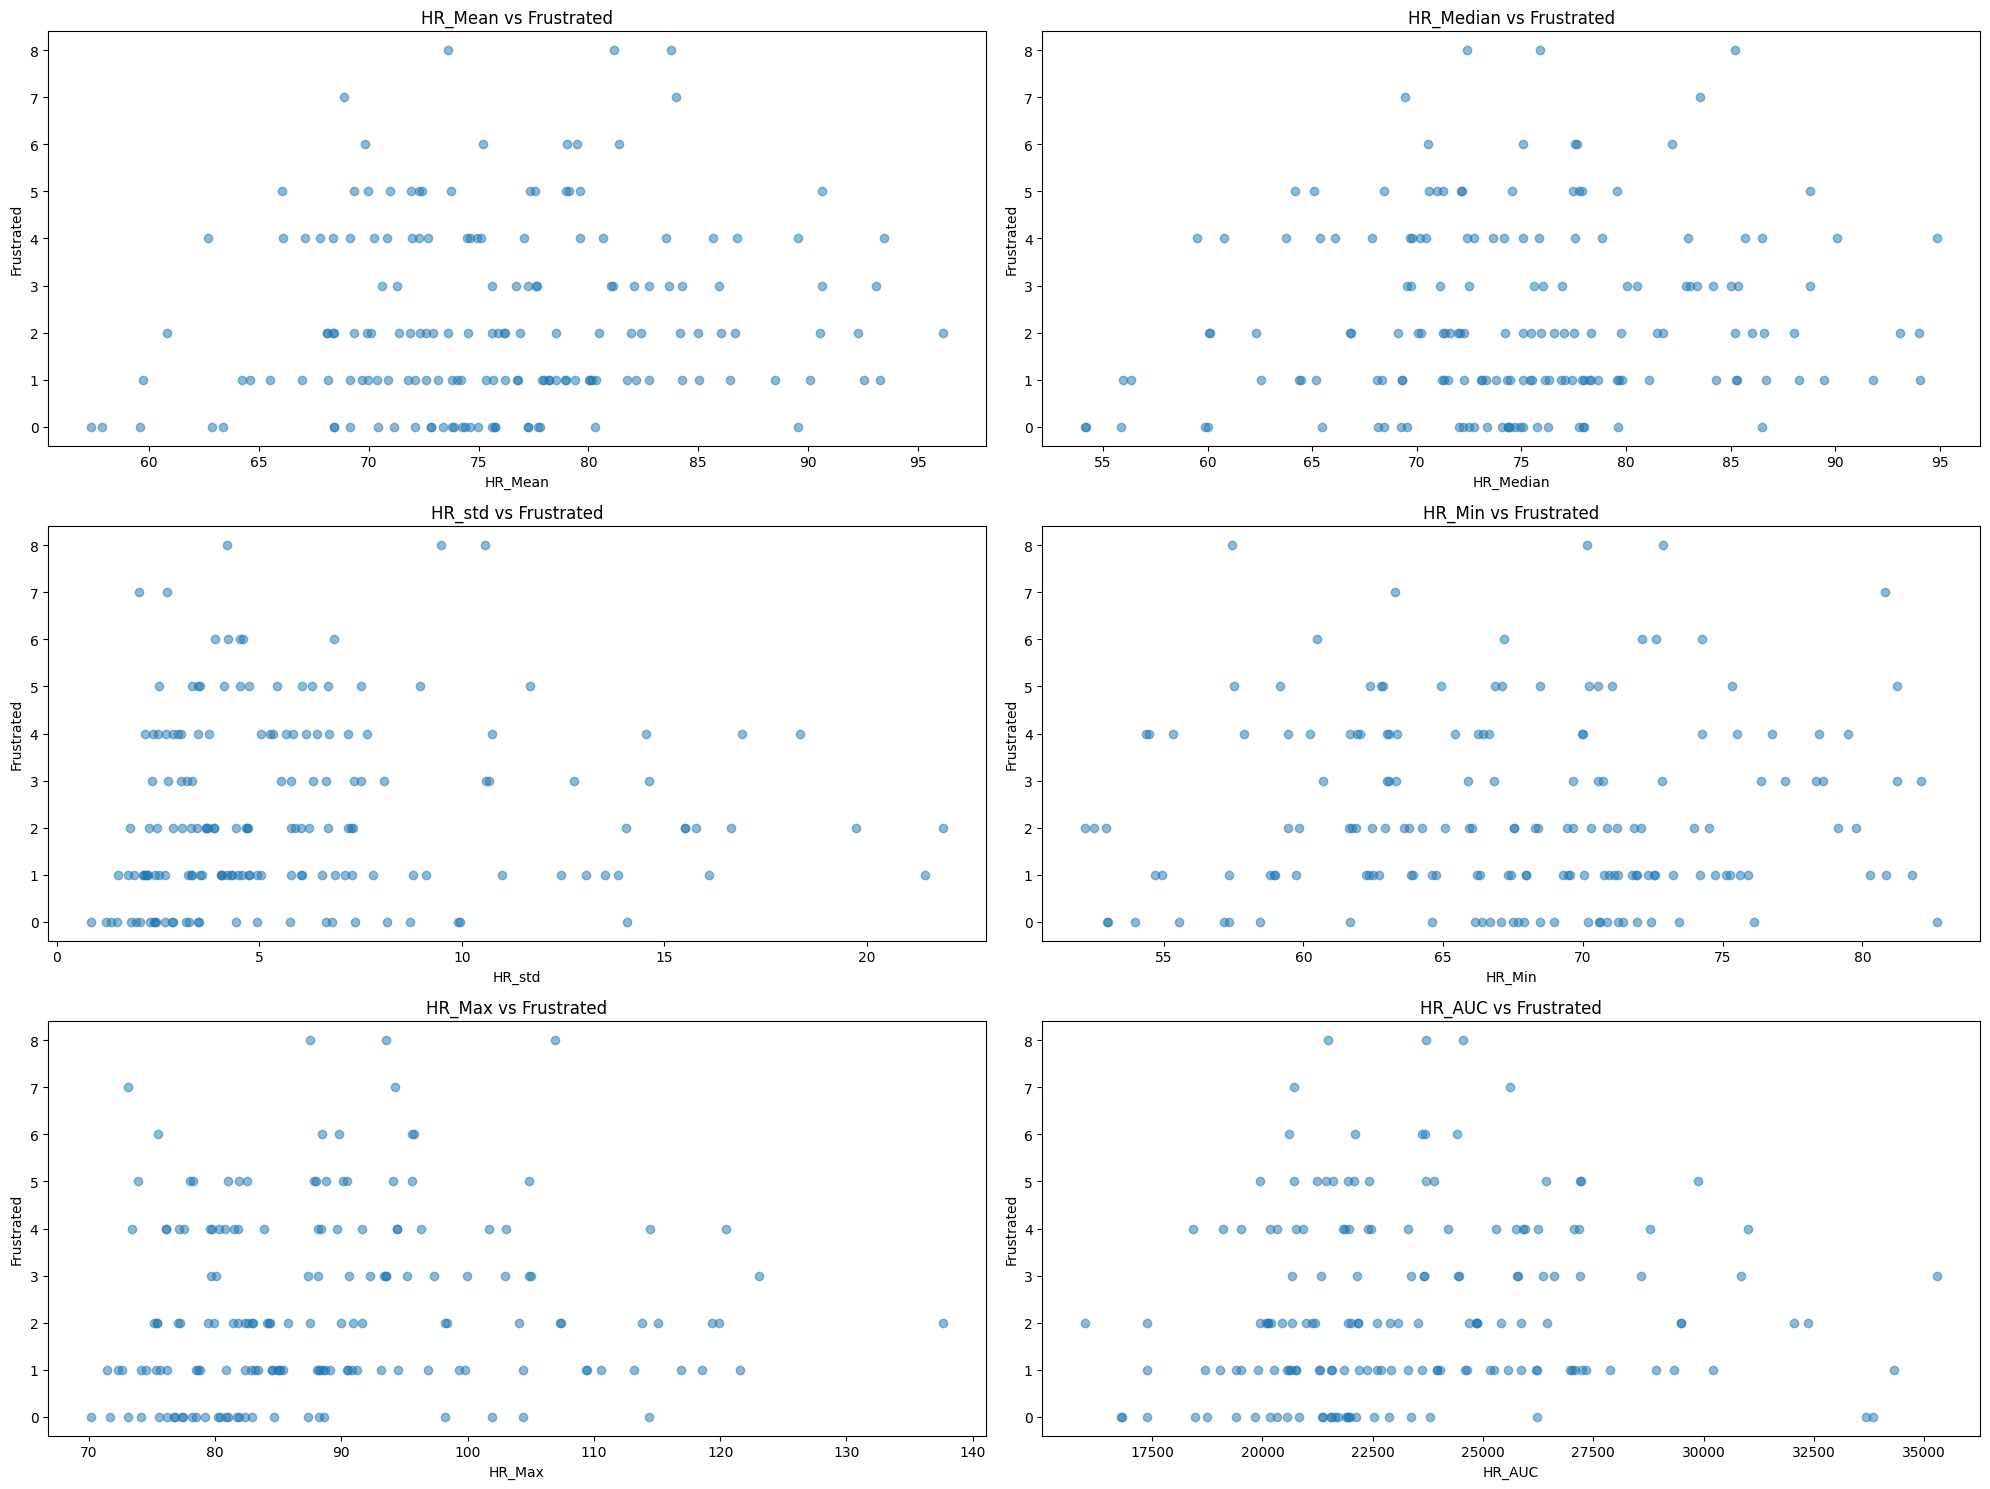

In [179]:
features = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']

plt.figure(figsize=(20, 15))

for i, feature in enumerate(features):
    plt.subplot(3, 2, i + 1)
    plt.scatter(HR_data[feature], HR_data['Frustrated'], alpha=0.5)
    plt.title(f'{feature} vs Frustrated')
    plt.xlabel(feature)
    plt.ylabel('Frustrated')

plt.tight_layout()
plt.show()

Setup folds for crossvalidation

In [3]:
unique_combinations = HR_data[['Cohort', 'Round']].drop_duplicates().values

# Create folds (note that there are different individuals in different cohorts, so we do not have to account for individuals explicitly)
folds = []
for cohort, round_ in unique_combinations:
    test_mask = (HR_data['Cohort'] == cohort) & (HR_data['Round'] == round_)
    train_mask = ~((HR_data['Cohort'] == cohort) | (HR_data['Round'] == round_))
    
    test_data = HR_data[test_mask]
    train_data = HR_data[train_mask]
    
    folds.append((train_data, test_data))

Obtain errors for all different types of models:

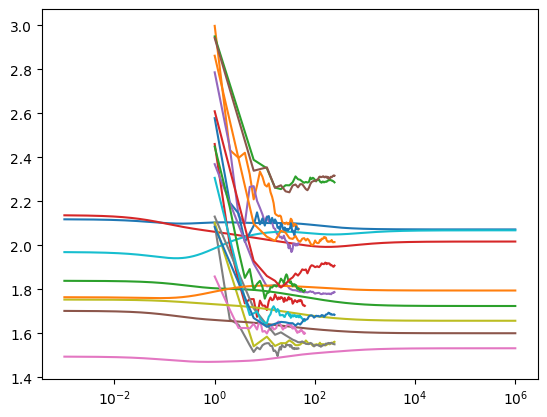

In [9]:
errors = {'Baseline':[], 'Ridge':[], 'KNN':[], 'RF':[], 'ANN':[], 'Logistic':[]}
for par_data, val_data in folds:
    scaler.fit(par_data[inputcols])
    x_par = scaler.transform(par_data[inputcols])
    y_par = par_data['Frustrated']
    x_val = scaler.transform(val_data[inputcols])
    y_val = val_data['Frustrated']

    baseline = np.mean(y_par)
    baseline_errors = (y_val - baseline)**2
    errors['Baseline'].append(baseline_errors)

    ANN_model_params = find_best_ANN(x_par, y_par.values)
    model = ANNModel()
    model.load_state_dict(ANN_model_params)
    ANN_errors = ((model(torch.tensor(x_val).float())).detach().numpy()-y_val.values)**2
    errors['ANN'].append(ANN_errors)

    Ridge_hyperparams = find_best_Ridge(x_par, y_par.values)
    ridge_model = Ridge(alpha = Ridge_hyperparams)
    ridge_model.fit(x_par, y_par)
    ridge_errors = (ridge_model.predict(x_val)-y_val.values)**2
    errors['Ridge'].append(ridge_errors)

    KNN_hyperparams = int(find_best_KNN(x_par, y_par.values))
    KNN_model = KNeighborsRegressor(n_neighbors = KNN_hyperparams)
    KNN_model.fit(x_par, y_par)
    KNN_errors = (KNN_model.predict(x_val)-y_val.values)**2
    errors['KNN'].append(KNN_errors)

    RF_hyperparams = int(find_best_RF(x_par, y_par.values))
    RF_model = RandomForestRegressor(n_estimators = RF_hyperparams)
    RF_model.fit(x_par, y_par)
    RF_errors = (RF_model.predict(x_val)-y_val.values)**2
    errors['RF'].append(RF_errors)

    logistic_hyperparams = find_best_logistic(x_par, y_par.values)
    logistic_model = LogisticRegression(C=logistic_hyperparams, penalty='l2',max_iter = 10**6)
    logistic_model.fit(x_par, y_par)
    logistic_errors = (logistic_model.predict(x_val)-y_val.values)**2
    errors['Logistic'].append(logistic_errors)


The structure of errors_df was horrible, so I restructured below and save to a .csv file:

In [95]:
unique_folds = errors_df['Fold'].unique()

all_data = [0 for i in range(168)]

# Loop through each fold and print the fold number
for fold in unique_folds:
    fold_df = errors_df[errors_df['Fold'] == fold]
    print(f'Data for fold {fold}:')
    # display(fold_df)
    print()  # For better readability
    # Extract the data where "Model" is "Baseline"
    baseline_data = fold_df[fold_df['Model'] == 'Baseline']
    ANN_data = fold_df[fold_df['Model'] == 'ANN']
    Ridge_data = fold_df[fold_df['Model'] == 'Ridge']
    KNN_data = fold_df[fold_df['Model'] == 'KNN']
    RF_data = fold_df[fold_df['Model'] == 'RF']
    Logistic_data = fold_df[fold_df['Model'] == 'Logistic']

    baseline_data = baseline_data['Error'][baseline_data['Error'].index[0]]
    ANN_data = ANN_data['Error'][ANN_data['Error'].index[0]]
    Ridge_data = Ridge_data['Error'][Ridge_data['Error'].index[0]]
    KNN_data = KNN_data['Error'][KNN_data['Error'].index[0]]
    RF_data = RF_data['Error'][RF_data['Error'].index[0]]
    Logistic_data = Logistic_data['Error'][Logistic_data['Error'].index[0]]

    print(len(baseline_data))
    for i in range(len(baseline_data)):
        datapoint, baseline_error = baseline_data.index[i], baseline_data.values[i]
        ANN_error = ANN_data[i]
        Ridge_error = Ridge_data[i]
        KNN_error = KNN_data[i]
        RF_error = RF_data[i]
        Logistic_error = Logistic_data[i]
        # print(datapoint, baseline_error, Ridge_error, KNN_error, RF_error, ANN_error, Logistic_error)

        all_data[datapoint]=({
            'Fold': fold,
            'Baseline Error': baseline_error,
            'Ridge Error': Ridge_error,
            'KNN Error': KNN_error,
            'RF Error': RF_error,
            'ANN Error': ANN_error,
            'Logistic Error': Logistic_error
        })

final_df = pd.DataFrame(all_data)
final_df
final_df.to_csv('final_errors.csv', index = True)

Data for fold 0:

24
Data for fold 1:

24
Data for fold 2:

24
Data for fold 3:

24
Data for fold 4:

18
Data for fold 5:

18
Data for fold 6:

18
Data for fold 7:

18


Do repeated measures one-way anova:

First I have to reshape the data to long format

In [102]:
df_long = pd.melt(final_df.reset_index(), id_vars=['index', 'Fold'], var_name='Model', value_name='Error')
df_long.rename(columns={'index': 'Subject'}, inplace=True)
df_long

,Subject,Fold,Model,Error
0,0,0,Baseline Error,0.757545
1,1,0,Baseline Error,9.794582
2,2,0,Baseline Error,3.498285
3,3,1,Baseline Error,0.521605
4,4,1,Baseline Error,10.743827
...,...,...,...,...
1003,163,6,Logistic Error,36.000000
1004,164,6,Logistic Error,4.000000
1005,165,7,Logistic Error,1.000000
1006,166,7,Logistic Error,4.000000


Now I can do ANOVA

In [105]:
aovrm = AnovaRM(df_long, 'Error', 'Subject', within=['Model'])
res = aovrm.fit()
res.anova_table

,F Value,Num DF,Den DF,Pr > F
Model,11.276563,5.0,835.0,1.534747e-10


Check assumptions, first, is data normally distributed?

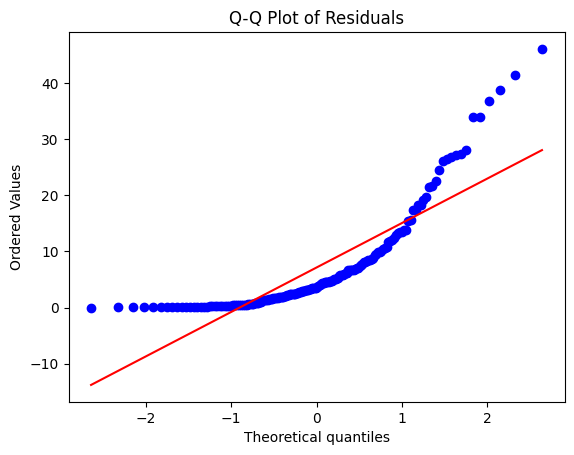

In [123]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q-Q plot
stats.probplot(final_df['ANN Error'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()



Already no, what about with log transformation?

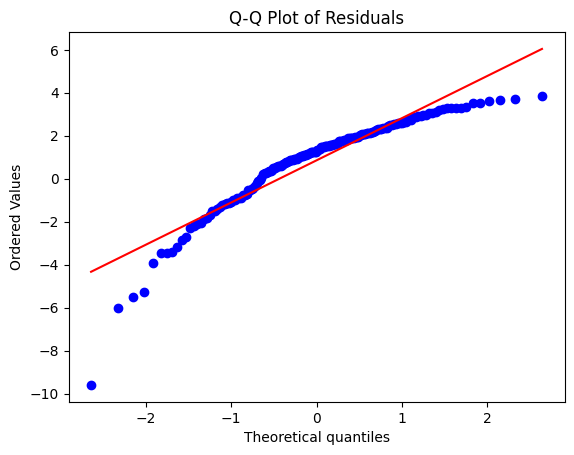

In [124]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q-Q plot
stats.probplot(np.log(final_df['ANN Error']), dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()



not either. Therefore I need to use non-parametric alternative:

In [140]:
# Remove the Fold column
df_wide = final_df.drop(columns=['Fold'])
# display(df_wide)

# Perform the Friedman test
stat, p = stats.friedmanchisquare(*[df_wide[model].values for model in df_wide.columns])


print(f'Friedman Test: Statistic={stat:.3f}, p={p:.3e}')

Friedman Test: Statistic=24.731, p=1.570e-04


Make pairwise comparisons with paired t.tests. Use setup II from the 02450 machine learning book

In [174]:
for model1, model2 in combinations(df_wide.columns, 2):
    # display(final_df[final_df['Fold'] == 0])
    rjs = []
    for i in range(8):
        rjs.append(np.mean(final_df[final_df['Fold'] == i][model1] - final_df[final_df['Fold'] == i][model2]))
    # print(rjs)
    rjs = np.array(rjs)
    mean = np.mean(rjs)
    s2 = 1/7 * np.sum((rjs - mean)**2)
    o2 = (1/8+1/7)*s2
    t = mean/np.sqrt(o2)
    print(f'Paired t-test between {model1} and {model2}: mean={mean:.2f}, std = {np.sqrt(s2):.2f}, t={t:.3f}, p={2*stats.t.sf(np.abs(t), 7):.3f}')


Paired t-test between Baseline Error and Ridge Error: mean=-13.75, std = 39.03, t=-0.680, p=0.518
Paired t-test between Baseline Error and KNN Error: mean=0.05, std = 0.44, t=0.229, p=0.826
Paired t-test between Baseline Error and RF Error: mean=-0.37, std = 0.58, t=-1.235, p=0.257
Paired t-test between Baseline Error and ANN Error: mean=-2.53, std = 2.50, t=-1.958, p=0.091
Paired t-test between Baseline Error and Logistic Error: mean=-1.88, std = 2.36, t=-1.540, p=0.167
Paired t-test between Ridge Error and KNN Error: mean=13.80, std = 38.66, t=0.690, p=0.513
Paired t-test between Ridge Error and RF Error: mean=13.38, std = 39.17, t=0.660, p=0.531
Paired t-test between Ridge Error and ANN Error: mean=11.21, std = 37.16, t=0.583, p=0.578
Paired t-test between Ridge Error and Logistic Error: mean=11.87, std = 38.23, t=0.600, p=0.568
Paired t-test between KNN Error and RF Error: mean=-0.42, std = 0.85, t=-0.961, p=0.368
Paired t-test between KNN Error and ANN Error: mean=-2.59, std = 2.3

Do the same comparisons with normal paired t-tests

In [172]:
# Make pairwise comparisons between the 6 models with paired t.tests

# Perform the pairwise comparisons
for model1, model2 in combinations(df_wide.columns, 2):
    stat, p = stats.ttest_rel(df_wide[model1], df_wide[model2])
    diff = df_wide[model1] - df_wide[model2]
    print(f'{model1} vs. {model2}: Mean={np.mean(diff):.2f}, sd = {np.std(diff-np.mean(diff),ddof =1):.2f} Statistic={stat:.3f}, p={p:.5f}')


Baseline Error vs. Ridge Error: Mean=-15.71, sd = 58.01 Statistic=-3.511, p=0.00057
Baseline Error vs. KNN Error: Mean=0.05, sd = 2.49 Statistic=0.244, p=0.80718
Baseline Error vs. RF Error: Mean=-0.34, sd = 3.61 Statistic=-1.231, p=0.22000
Baseline Error vs. ANN Error: Mean=-2.65, sd = 8.35 Statistic=-4.123, p=0.00006
Baseline Error vs. Logistic Error: Mean=-2.08, sd = 5.13 Statistic=-5.247, p=0.00000
Ridge Error vs. KNN Error: Mean=15.76, sd = 56.84 Statistic=3.594, p=0.00043
Ridge Error vs. RF Error: Mean=15.37, sd = 58.21 Statistic=3.423, p=0.00078
Ridge Error vs. ANN Error: Mean=13.06, sd = 55.40 Statistic=3.055, p=0.00262
Ridge Error vs. Logistic Error: Mean=13.64, sd = 56.79 Statistic=3.113, p=0.00218
KNN Error vs. RF Error: Mean=-0.39, sd = 3.73 Statistic=-1.357, p=0.17658
KNN Error vs. ANN Error: Mean=-2.70, sd = 7.35 Statistic=-4.764, p=0.00000
KNN Error vs. Logistic Error: Mean=-2.12, sd = 5.32 Statistic=-5.171, p=0.00000
RF Error vs. ANN Error: Mean=-2.31, sd = 8.26 Statist

Means within each fold

In [11]:
for i in range(8):
    print('Fold', i)
    print('Baseline:', np.mean(errors['Baseline'][i]))
    print('ANN:', np.mean(errors['ANN'][i]))
    print('Ridge:', np.mean(errors['Ridge'][i]))
    print('KNN:', np.mean(errors['KNN'][i]))
    print('RF:', np.mean(errors['RF'][i]))
    print('Logistic:', np.mean(errors['Logistic'][i]))

Fold 0
Baseline: 2.825445816186557
ANN: 6.7994231348872605
Ridge: 2.825457504326401
KNN: 2.670118454806096
RF: 3.0855064247921384
Logistic: 5.041666666666667
Fold 1
Baseline: 5.854938271604937
ANN: 8.89029778044321
Ridge: 5.5892517540408555
KNN: 5.401023644752018
RF: 5.692652329749104
Logistic: 11.541666666666666
Fold 2
Baseline: 5.141803840877915
ANN: 4.373255481726328
Ridge: 5.148866954344389
KNN: 4.83616255144033
RF: 5.737366255144033
Logistic: 6.208333333333333
Fold 3
Baseline: 2.00960219478738
ANN: 9.273163358037772
Ridge: 112.34898403287805
KNN: 2.8697916666666665
RF: 2.035224597442561
Logistic: 6.041666666666667
Fold 4
Baseline: 4.335069444444445
ANN: 6.748247207164997
Ridge: 4.335092125413221
KNN: 4.375283446712018
RF: 4.822208745435986
Logistic: 2.888888888888889
Fold 5
Baseline: 3.846450617283951
ANN: 4.460979385859954
Ridge: 3.846461953015034
KNN: 3.910817901234568
RF: 3.3974871964208253
Logistic: 3.5
Fold 6
Baseline: 7.481674382716049
ANN: 8.005234563789655
Ridge: 7.4816543

Mean errors of all models over all 168 datapoints

In [196]:
for model in ['Baseline Error', 'Ridge Error', 'KNN Error', 'RF Error', 'ANN Error', 'Logistic Error']:
    print(np.mean(final_df.mean()[model]))

4.47766479276896
20.1909721879964
4.430674756116055
4.820745187945399
7.132491799029145
6.553571428571429


Robustness of models when changing data calculations:

In [197]:
for model in ['Baseline Error', 'Ridge Error', 'KNN Error', 'RF Error', 'ANN Error', 'Logistic Error']:
    print(model," standard deviation:",sep="")
    print(np.std([final_df[final_df['Fold'] == i].mean()[model] for i in range(8)], ddof=1))
    print()

Baseline Error standard deviation:
1.725245169581837

Ridge Error standard deviation:
38.02187685602264

KNN Error standard deviation:
1.547901930100556

RF Error standard deviation:
2.0369347531699784

ANN Error standard deviation:
1.8769989950431802

Logistic Error standard deviation:
2.8135200482186713



Test functions and show hyperparameter optimization graph

array([7.57535911e-01, 9.79482121e+00, 3.49818443e+00, 1.68164897e-02,
       4.53535801e+00, 7.57601471e-01, 1.27600236e+00, 4.53522796e+00,
       1.27595647e+00, 1.68165128e-02, 1.27595570e+00, 1.68243916e-02,
       7.57460939e-01, 1.27613166e+00, 1.68136170e-02, 9.79484454e+00,
       1.67997945e-02, 1.67948786e-02, 1.27604237e+00, 1.70537411e+01,
       4.53559811e+00, 1.68112409e-02, 4.53534811e+00, 7.57492842e-01])

2.825457504326401

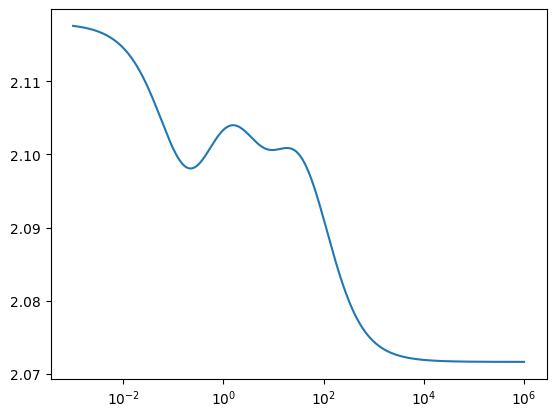

In [7]:
Ridge_hyperparams = find_best_Ridge(x_par, y_par.values)
ridge_model = Ridge(alpha = Ridge_hyperparams)
ridge_model.fit(x_par, y_par)
ridge_errors = (ridge_model.predict(x_val)-y_val.values)**2
display(ridge_errors)
np.mean(ridge_errors)

array([9.16704391e-01, 9.38705297e+00, 3.83159801e+00, 4.07424174e-03,
       4.25939339e+00, 9.57899502e-01, 1.00000000e+00, 4.00000000e+00,
       1.00000000e+00, 4.07424174e-03, 1.00000000e+00, 7.24309642e-03,
       8.37030330e-01, 1.13173382e+00, 4.07424174e-03, 9.38705297e+00,
       0.00000000e+00, 0.00000000e+00, 1.04300589e+00, 1.60000000e+01,
       4.25939339e+00, 4.07424174e-03, 4.17202354e+00, 8.76414667e-01])

2.670118454806096

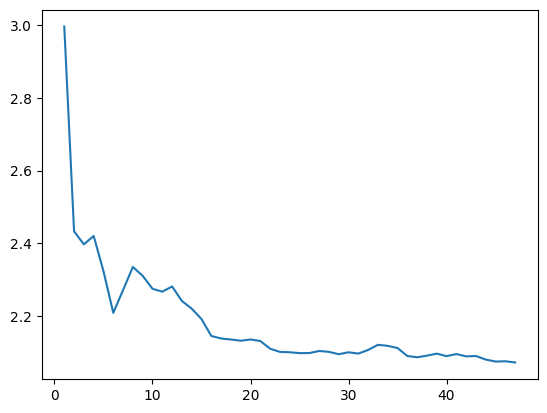

In [ ]:
KNN_hyperparams = int(find_best_KNN(x_par, y_par.values))
KNN_model = KNeighborsRegressor(n_neighbors = KNN_hyperparams)
KNN_model.fit(x_par, y_par)
KNN_errors = (KNN_model.predict(x_val)-y_val.values)**2
display(KNN_errors)
np.mean(KNN_errors)

array([6.55328798e-01, 7.36734694e+00, 3.44897959e+00, 3.83219955e-01,
       2.62131519e+00, 2.04081633e+00, 0.00000000e+00, 6.85941043e+00,
       2.26757370e-01, 7.34693878e-01, 9.07029478e-01, 5.10204082e-01,
       2.26757370e-01, 1.53287982e+00, 5.66893424e-02, 1.11111111e+01,
       9.07029478e-03, 5.80498866e-01, 2.62131519e+00, 1.63832200e+01,
       8.16326531e+00, 1.09750567e+00, 6.13151927e+00, 3.62811791e+00])

3.220710506424792

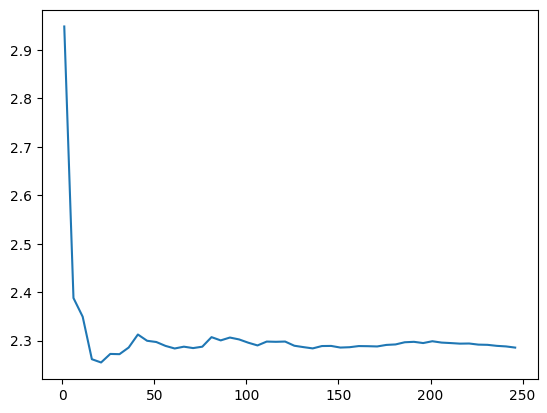

In [5]:
RF_hyperparams = int(find_best_RF(x_par, y_par.values))
RF_model = RandomForestRegressor(n_estimators = RF_hyperparams)
RF_model.fit(x_par, y_par)
RF_errors = (RF_model.predict(x_val)-y_val.values)**2
display(RF_errors)
np.mean(RF_errors)

In [6]:
logistic_hyperparams = find_best_logistic(x_par, y_par.values)
logistic_model = LogisticRegression(C=logistic_hyperparams, penalty='l2',max_iter = 10**6)
logistic_model.fit(x_par, y_par)
logistic_errors = (logistic_model.predict(x_val)-y_val.values)**2
display(logistic_errors)
np.mean(logistic_errors)

array([ 0, 16,  1,  1,  9,  0,  4,  9,  4,  1,  4,  1,  0,  4,  1, 16,  1,
        1,  4, 25,  9,  1,  9,  0], dtype=int64)

5.041666666666667